In [1]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

### Funciones

In [18]:
#Function to split the training data into X,y datasets
def load_dataset(scene_in = "modular02a", date = "2023_15_11"):
    # Defining usefull variables
    path = os.getcwd() + "\\training\\training_data\\" + date
    file_list = os.listdir(path)
    scene_files_list = [item for item in file_list if scene_in in item and "pkl" in item]


    file = open(path + "\\" + scene_files_list[0], "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    post_j_positions_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)


    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns


    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns


    #Builds the X dataframe
    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_pos_x"], training_df["prev_pos_y"], training_df["prev_pos_z"]], 
                    axis="columns")


    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns


    #Builds the y dataframe
    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_pos_x"], training_df["post_pos_y"], training_df["post_pos_z"]], 
                    axis="columns")

    return(X_df,y_df)

In [3]:
def adapt_X_y(X_a,y_a):
    X_a_cols = ['current_state_x', 'current_state_y', 'current_state_z', 'joint0_current_state_rad', 'joint1_current_state_rad', 'joint2_current_state_rad'
                , 'joint0_actions_rad', 'joint1_actions_rad', 'joint2_actions_rad']

    X_a = pd.concat([X_a["prev_pos_x"], X_a["prev_pos_y"] , X_a["prev_pos_z"],
                X_a["prev_j_positions_0"], X_a["prev_j_positions_1"], X_a["prev_j_positions_2"],
                X_a["increments_0"], X_a["increments_1"], X_a["increments_2"]], 
                        axis="columns")

    X_a.columns = X_a_cols

    y_a_cols = ['future_state_x', 'future_state_y', 'future_state_z', 'joint0_future_state_rad', 'joint1_future_state_rad', 'joint2_future_state_rad']

    y_a = pd.concat([y_a["post_pos_x"], y_a["post_pos_y"] , y_a["post_pos_z"],
                y_a["post_j_positions_0"], y_a["post_j_positions_1"], y_a["post_j_positions_2"]], 
                        axis="columns")
    y_a.columns = y_a_cols
    return X_a, y_a

In [4]:
def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.legend()
  plt.show()

In [5]:
def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    max_list = []
    min_list = []
    mse_list = []
    perc_mse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num], s=1, color = "red")

        #Getting important values
        minim = min(test.iloc[:,column_num])
        min_list.append(minim)
        maxim = max(test.iloc[:,column_num])
        max_list.append(maxim)
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(round(mse,6))
        rang = (maxim-minim)
        perc = mse/rang *100
        perc_mse_list.append(round(perc,6))
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    data = {"Perception": columns, "Max.": max_list, "Min.": min_list, "Mse": mse_list, "Mse perc.": perc_mse_list}
    data_df = pd.DataFrame(data)
    return(data_df)

In [6]:
def export_model(exp_scene, exp_model, exp_scaler):
    timestr = time.strftime("_%Y_%d_%m")
    models_path = "models\\" + timestr[1:]
    if not os.path.exists(models_path):
        os.mkdir(models_path)
        print(f"Directorio '{models_path}' ha sido creado.")
    else:
        print(f"El directorio '{models_path}' ya existe.")
    exp_model.save(models_path + "\\model_" + exp_scene + timestr + ".keras")
    with open(models_path + "\\model_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_model, file)
    with open(models_path + "\\scaler_" + exp_scene + timestr + '.pkl', 'wb') as file:
        pickle.dump(exp_scaler, file)

### Modular03

In [19]:
scene = "modular03"
X, y =load_dataset(scene)
X, y = adapt_X_y(X,y)
X

,current_state_x,current_state_y,current_state_z,joint0_current_state_rad,joint1_current_state_rad,joint2_current_state_rad,joint0_actions_rad,joint1_actions_rad,joint2_actions_rad
0,0.000005,-2.627625e-06,0.312299,0.000000,-2.384186e-07,-4.768372e-07,0.001075,0.003463,0.123184
1,-0.004265,-2.381539e-06,0.312055,0.001080,3.479242e-03,1.237686e-01,0.111915,0.003041,0.091939
2,-0.028481,1.068199e-05,0.309505,0.113475,6.547689e-03,2.166352e-01,0.001167,0.026358,-0.067827
3,-0.029715,-7.280465e-06,0.309549,0.115057,3.304744e-02,1.492796e-01,0.011758,0.045390,-0.029686
4,-0.036020,7.554601e-06,0.308342,0.127217,7.876229e-02,1.198514e-01,0.118796,-0.009942,0.031674
...,...,...,...,...,...,...,...,...,...
34995,0.020711,-5.483739e-06,0.282210,-0.427504,2.256582e-01,1.494674e+00,0.024815,-0.058478,-0.117399
34996,0.023024,-7.803838e-06,0.286583,-0.402234,1.668916e-01,1.377607e+00,-0.003659,0.082714,0.106273
34997,0.015237,2.160900e-06,0.282553,-0.405524,2.497325e-01,1.484664e+00,0.062984,-0.057197,-0.022403
34998,0.010134,1.630040e-06,0.284910,-0.341963,1.923840e-01,1.462816e+00,0.076683,0.116757,-0.093605


In [20]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape,X_test.shape

((28000, 9), (7000, 9))

In [21]:
y_train.shape,y_test.shape

((28000, 6), (7000, 6))

In [22]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(28000, 9)

In [23]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=9, input_dim=9, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=27, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=6, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=20, validation_split=0.2)

Epoch 1/50


1120/1120 [==============================] - 2s 1ms/step - loss: 0.0313 - val_loss: 0.0013
Epoch 2/50
1120/1120 [==============================] - 1s 1ms/step - loss: 6.7025e-04 - val_loss: 3.9915e-04
Epoch 3/50
1120/1120 [==============================] - 1s 1ms/step - loss: 2.6571e-04 - val_loss: 1.7922e-04
Epoch 4/50
1120/1120 [==============================] - 1s 1ms/step - loss: 1.3235e-04 - val_loss: 8.6337e-05
Epoch 5/50
1120/1120 [==============================] - 1s 1ms/step - loss: 7.1247e-05 - val_loss: 6.6074e-05
Epoch 6/50
1120/1120 [==============================] - 1s 1ms/step - loss: 6.0395e-05 - val_loss: 5.0299e-05
Epoch 7/50
1120/1120 [==============================] - 1s 1ms/step - loss: 5.8132e-05 - val_loss: 4.9841e-05
Epoch 8/50
1120/1120 [==============================] - 1s 1ms/step - loss: 5.5033e-05 - val_loss: 4.9471e-05
Epoch 9/50
1120/1120 [==============================] - 1s 1ms/step - loss: 5.3466e-05 - val_loss: 4.9336e-05
Epoch 10/50
1120/1120 [======

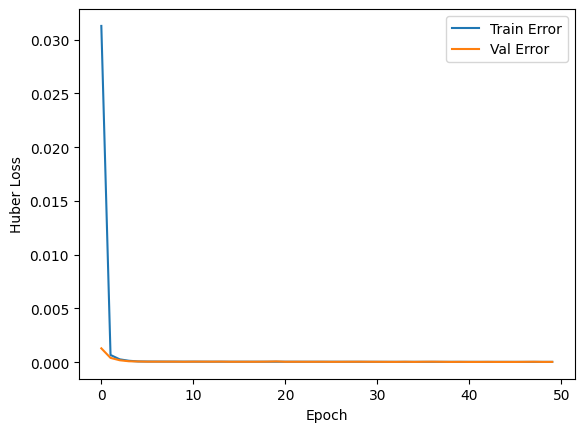

In [24]:
plot_history(history, "Huber")

In [25]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
df_test_predictions = pd.DataFrame(test_predictions)

219/219 [==============================] - 0s 786us/step


In [26]:
df_test_predictions.columns = y_test.columns

,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.185400,-0.184421,0.000037,0.009939
1,future_state_y,0.000029,-0.000044,0.000000,0.386393
2,future_state_z,0.312243,0.020542,0.000028,0.009698
3,joint0_future_state_rad,1.570797,-1.570798,0.000092,0.002943
4,joint1_future_state_rad,1.570797,-1.570797,0.000104,0.003305
5,joint2_future_state_rad,1.570797,-1.570797,0.000087,0.002760


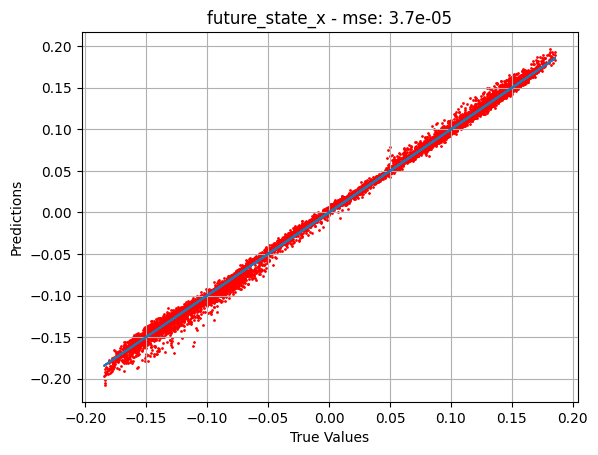

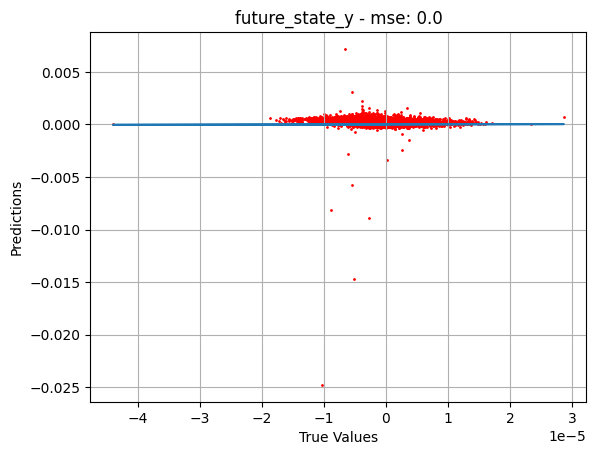

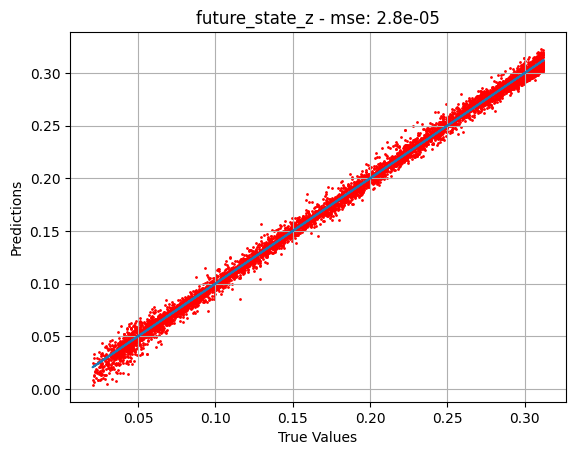

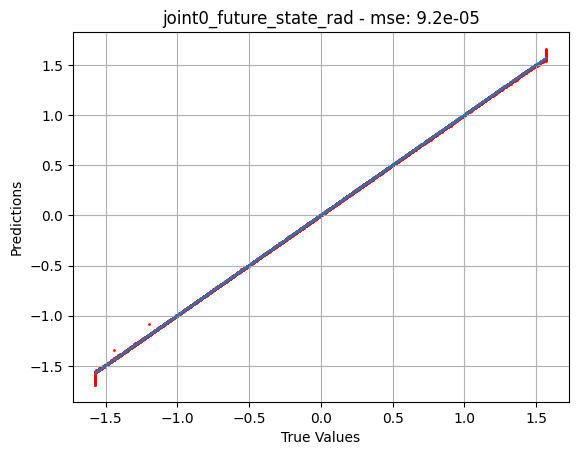

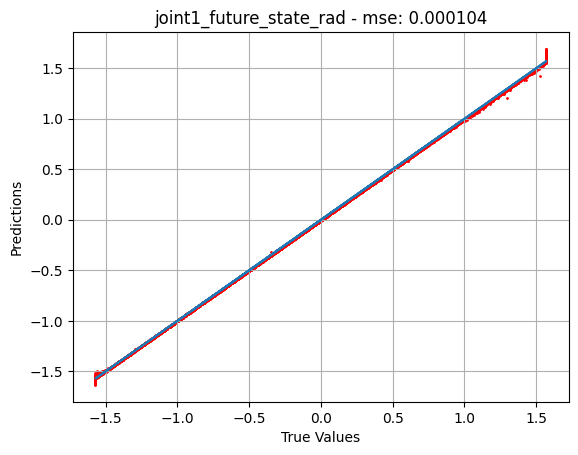

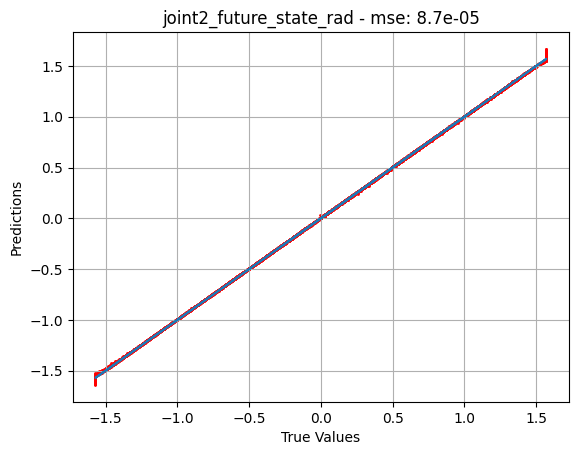

In [27]:
plot_pred_vs_test(y_test, df_test_predictions)

In [28]:
export_model(scene, model, scaler)

Directorio 'models\2023_29_11' ha sido creado.


### Comparacion de modelos

In [31]:
loaded = load_model('C:\\Users\\carlo\\OneDrive\\Imágenes\\Documentos\\GitHub\\EMERGE\\Morphology\\Multimodular\\models\\2023_15_11\\model_modular03_2023_15_11.keras')

219/219 [==============================] - 0s 798us/step


,Perception,Max.,Min.,Mse,Mse perc.
0,future_state_x,0.185400,-0.184421,0.000030,0.008182
1,future_state_y,0.000029,-0.000044,0.000001,1.041490
2,future_state_z,0.312243,0.020542,0.000041,0.013912
3,joint0_future_state_rad,1.570797,-1.570798,0.000098,0.003132
4,joint1_future_state_rad,1.570797,-1.570797,0.000101,0.003224
5,joint2_future_state_rad,1.570797,-1.570797,0.000105,0.003338


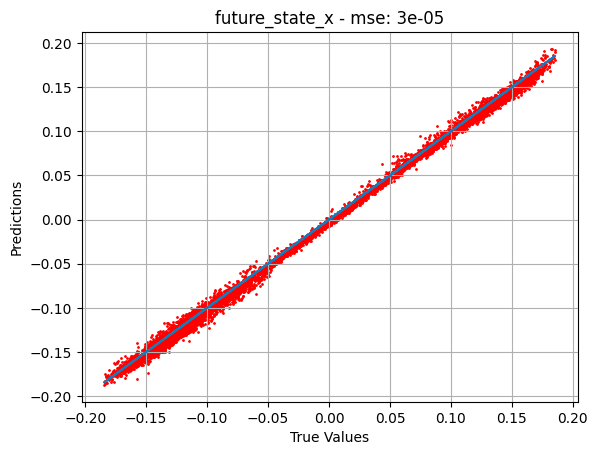

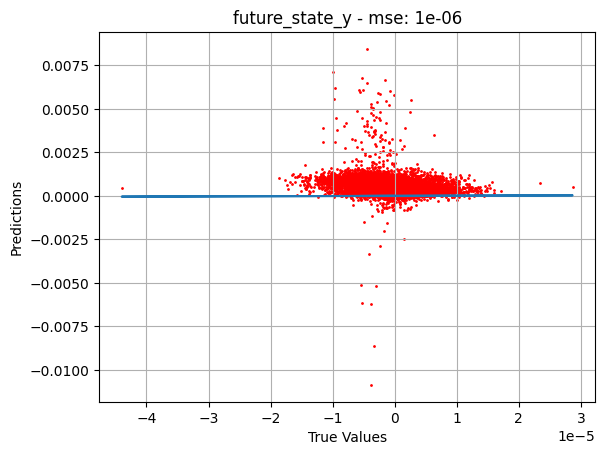

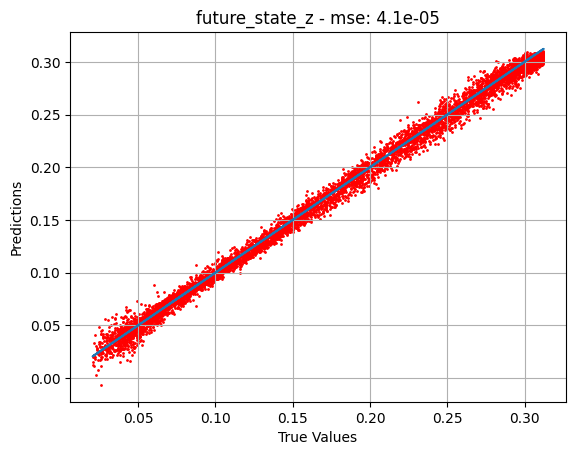

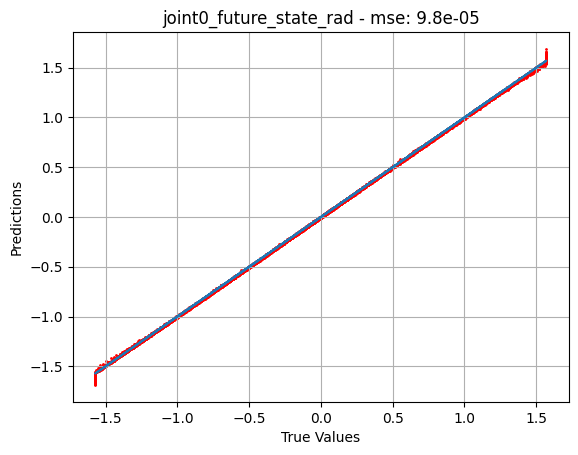

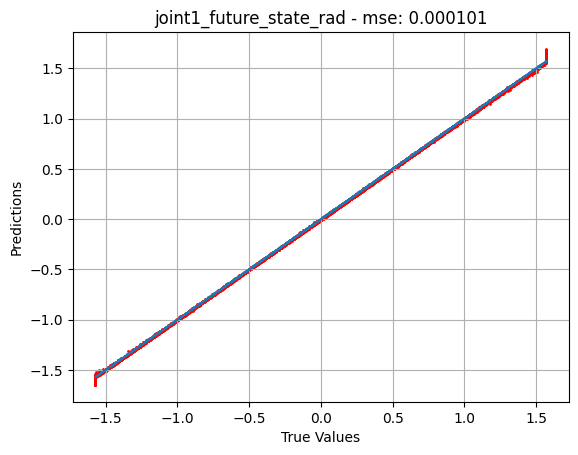

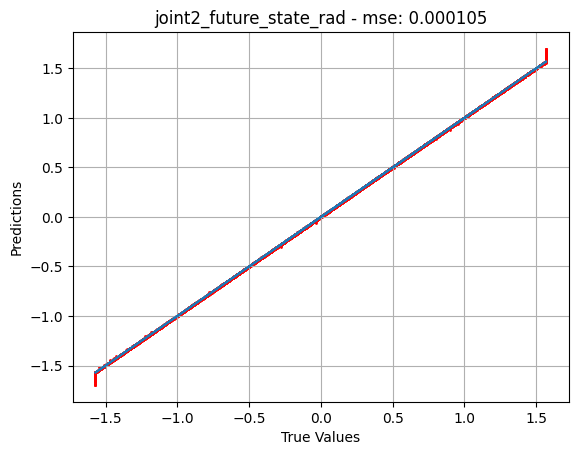

In [32]:
## Finalmente se hace uso de los datos de prueba para la predicción.
loaded_test_predictions = loaded.predict(X_test_scaled)
loaded_df_test_predictions = pd.DataFrame(loaded_test_predictions)
loaded_df_test_predictions.columns = y_test.columns
plot_pred_vs_test(y_test, loaded_df_test_predictions)

### Revisando valores extraños en X

In [ ]:
scene = "modular03"
path = os.getcwd() + "\\training_data\\2023_15_11"
file_list = os.listdir(path)
scene_files_list = [item for item in file_list if scene in item and "pkl" in item]

print(scene_files_list[0])

file = open(path + "\\" + scene_files_list[0], "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)

joined_training_dataset_modular03_2023_15_11_1045.pkl


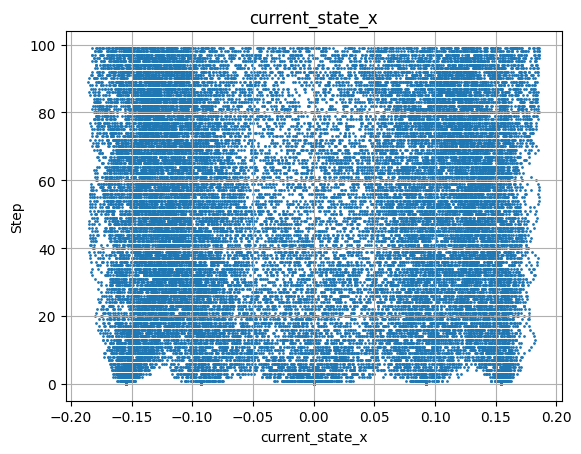

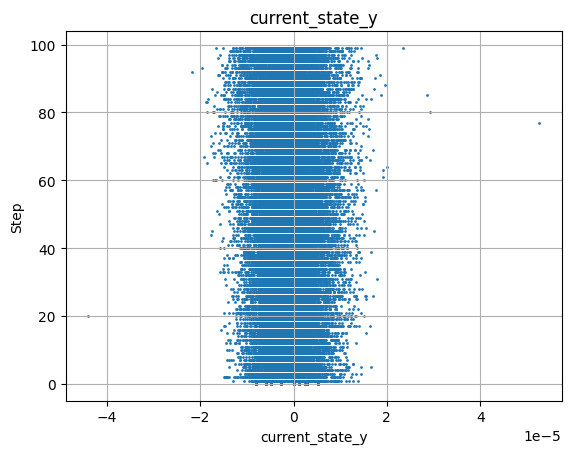

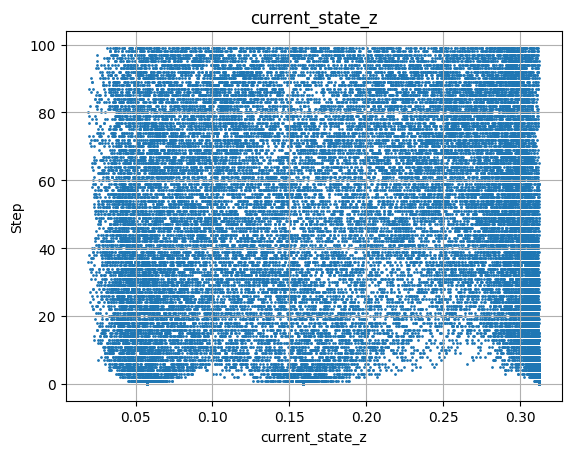

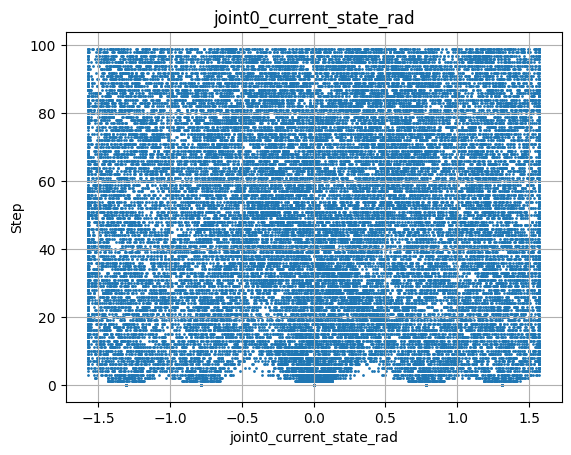

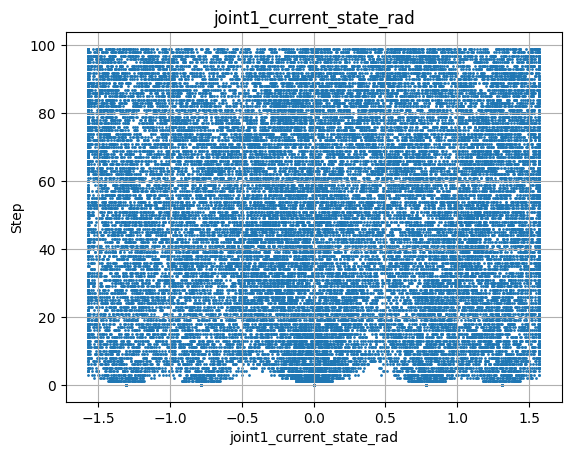

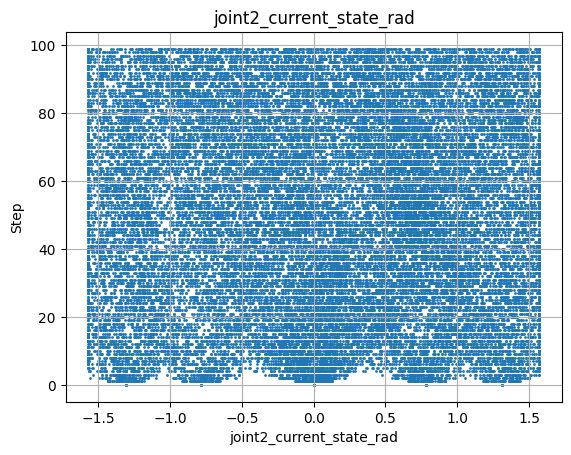

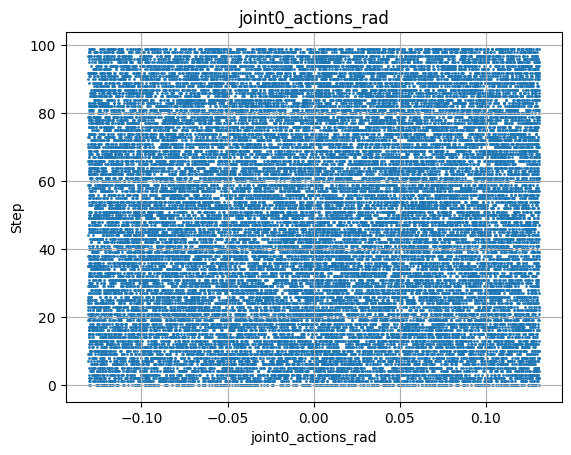

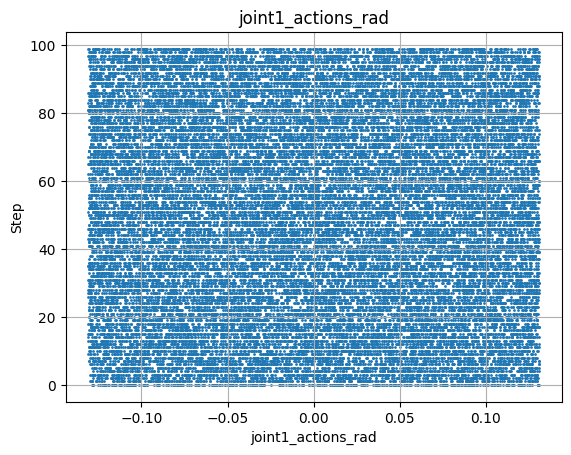

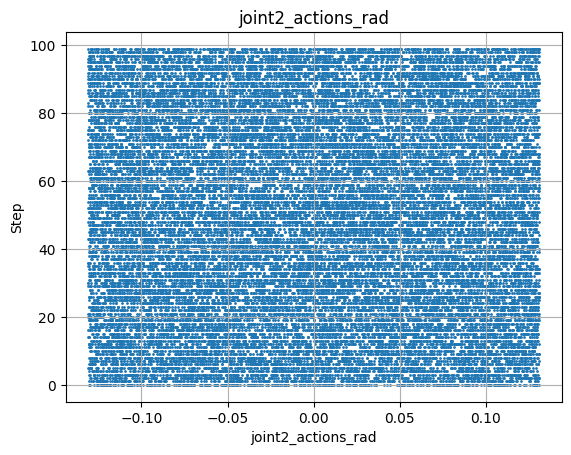

In [ ]:
## Se grafica la tabla de valores de entrenamiento para ver que tanto varian y si se tiene el rango necesario para la base.
columns = X_train.columns.tolist()
for col in range(-9,0):
    plt.figure()
    plt.scatter(X.iloc[:,col],training_df.iloc[:,1], s=1)
    plt.title(columns[col])
    plt.ylabel('Step')
    plt.xlabel(columns[col])
    plt.grid()

In [ ]:
X.columns

Index(['current_state_x', 'current_state_y', 'current_state_z',
       'joint0_current_state_rad', 'joint1_current_state_rad',
       'joint2_current_state_rad', 'joint0_actions_rad', 'joint1_actions_rad',
       'joint2_actions_rad'],
      dtype='object')

In [ ]:
maxim = max(X.iloc[:,0])
minim = min(X.iloc[:,0])
print("X minimo y maximo:",minim, maxim)

X minimo y maximo: -2.5550589561462402 2.5947868824005127


In [ ]:
maxim = max(X.iloc[:,0])
max_i = X['current_state_x'].tolist().index(maxim)
minim = min(X.iloc[:,0])
min_i = X['current_state_x'].tolist().index(minim)

In [ ]:
print("Fila del valor X maximo:",max_i)
print("sequence",training_df.iloc[max_i]["sequence"],"step",training_df.iloc[max_i]["step"])

Fila del valor X maximo: 33797
sequence 37 step 97


In [ ]:
df_max_X = X.loc[33700:33799]
df_max_X

,current_state_x,current_state_y,current_state_z,joint0_current_state_rad,joint1_current_state_rad,joint2_current_state_rad,joint0_actions_rad,joint1_actions_rad,joint2_actions_rad
33700,0.092209,-0.000003,0.032141,-1.308997,-1.308997,-1.308997,-0.021445,0.055232,0.068176
33701,0.097293,-0.000035,0.030490,-1.330533,-1.253517,-1.240496,-0.103099,-0.113043,0.061839
33702,0.082340,-0.000266,0.020844,-1.434103,-1.366835,-1.178080,-0.049366,-0.014533,0.082932
33703,0.084574,0.000102,0.019578,-1.483999,-1.381627,-1.093773,0.037941,-0.013828,0.117440
33704,0.092397,0.000920,0.017250,-1.446324,-1.395718,-0.974553,0.126412,-0.064612,0.113677
...,...,...,...,...,...,...,...,...,...
33795,2.594648,0.006355,0.119530,-1.068742,-0.430126,-0.952276,0.075823,-0.085907,0.130658
33796,2.594181,0.006400,0.126329,-0.992699,-0.515841,-0.820880,0.007262,-0.060855,0.112203
33797,2.594787,0.006414,0.123914,-0.985221,-0.576807,-0.707521,-0.011733,-0.130151,0.050869
33798,2.592193,0.006388,0.110231,-0.996821,-0.707633,-0.655439,0.064605,-0.098644,0.016162


In [ ]:
j0 = df_max_X.loc[33797]["joint0_current_state_rad"]*180/math.pi
j1 = df_max_X.loc[33797]["joint1_current_state_rad"]*180/math.pi
j2 = df_max_X.loc[33797]["joint2_current_state_rad"]*180/math.pi
print(j0,j1,j2)

-56.44898632016248 -33.04863528029374 -40.53797868634774


In [ ]:
df_max_X.columns.tolist()

['current_state_x',
 'current_state_y',
 'current_state_z',
 'joint0_current_state_rad',
 'joint1_current_state_rad',
 'joint2_current_state_rad',
 'joint0_actions_rad',
 'joint1_actions_rad',
 'joint2_actions_rad']

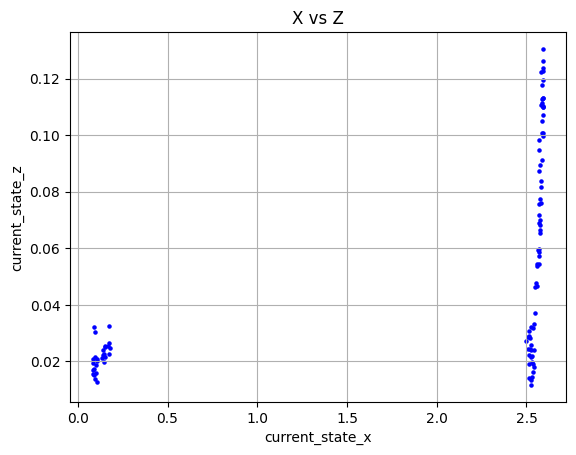

In [ ]:
columns = df_max_X.columns.tolist()
plt.figure()
plt.scatter(df_max_X["current_state_x"], df_max_X["current_state_z"], s=5, color='blue')
plt.title("X vs Z")
plt.xlabel("current_state_x")
plt.ylabel("current_state_z")
plt.grid()

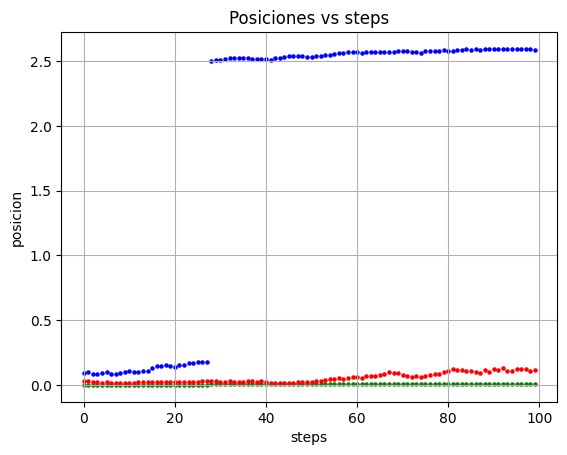

In [ ]:
columns = df_max_X.columns.tolist()
plt.figure()
plt.scatter(list(range(100)), df_max_X["current_state_x"], s=5, color='blue', label = "X")
plt.scatter(list(range(100)), df_max_X["current_state_y"], s=5, color='green', label = "Y")
plt.scatter(list(range(100)), df_max_X["current_state_z"], s=5, color='red', label = "Z")
plt.title(f"Posiciones vs steps")
plt.xlabel("steps")
plt.ylabel("posicion")
plt.grid()

In [ ]:
print("Fila del valor X minimo:", min_i)
print("sequence",training_df.iloc[min_i]["sequence"],"step",training_df.iloc[min_i]["step"])

Fila del valor X minimo: 1294
sequence 12 step 94


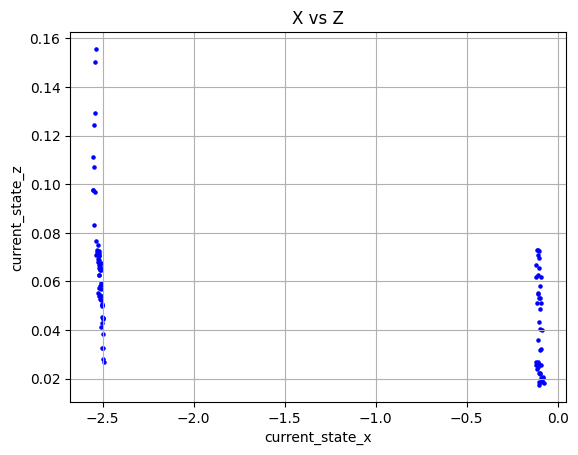

In [ ]:
df_min_X = X.loc[1200:1299]
columns = df_min_X.columns.tolist()
plt.figure()
plt.scatter(df_min_X["current_state_x"], df_min_X["current_state_z"], s=5, color='blue')
plt.title("X vs Z")
plt.xlabel("current_state_x")
plt.ylabel("current_state_z")
plt.grid()

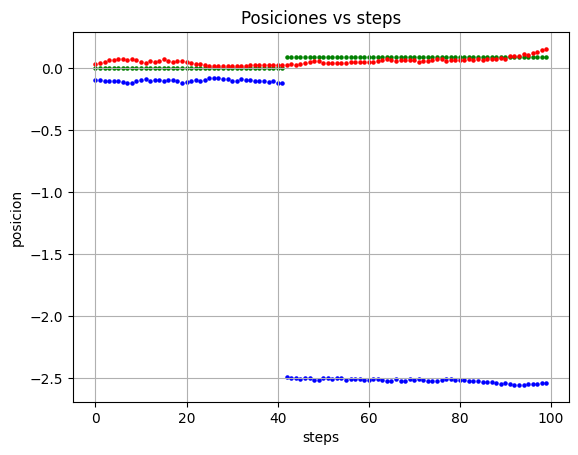

In [ ]:
columns = df_min_X.columns.tolist()
plt.figure()
plt.scatter(list(range(100)), df_min_X["current_state_x"], s=5, color='blue', label = "X")
plt.scatter(list(range(100)), df_min_X["current_state_y"], s=5, color='green', label = "Y")
plt.scatter(list(range(100)), df_min_X["current_state_z"], s=5, color='red', label = "Z")
plt.title(f"Posiciones vs steps")
plt.xlabel("steps")
plt.ylabel("posicion")
plt.grid()

### Revision de combinaciones

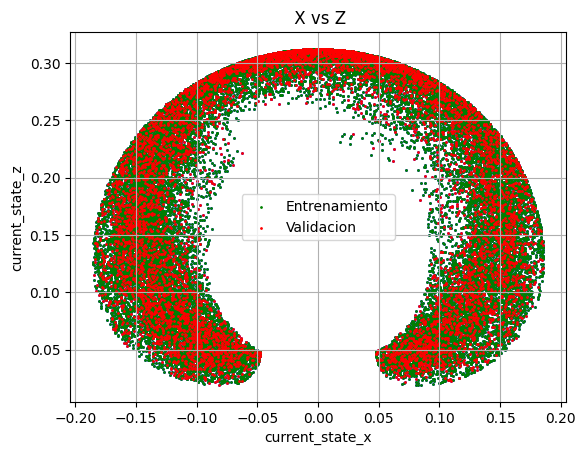

In [ ]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X.iloc[:,0],X.iloc[:,2], s=1, color='blue')
plt.scatter(X_train.iloc[:,0],X_train.iloc[:,2], s=1, color='green', label='Entrenamiento')
plt.scatter(X_test.iloc[:,0],X_test.iloc[:,2], s=1, color='red', label='Validacion')
plt.title(" X vs Z")
plt.ylabel(columns[2])
plt.xlabel(columns[0])
plt.legend()
plt.grid()

Intento para quitar datos extraños

In [ ]:
import pandas as pd

# Crear dos DataFrames de ejemplo
df1 = pd.DataFrame({'ID': [1, 2, 3], 'Nombre': ['Alice', 'Bob', 'Charlie']})
df2 = pd.DataFrame({'ID': [2, 3, 4], 'Edad': [25, 30, 35]})

# Concatenar DataFrames verticalmente
resultado = pd.concat([df1, df2], axis=0, ignore_index=True)

print(resultado)

   ID   Nombre  Edad
0   1    Alice   NaN
1   2      Bob   NaN
2   3  Charlie   NaN
3   2      NaN  25.0
4   3      NaN  30.0
5   4      NaN  35.0


In [ ]:
X_fix_1 = X.loc[:1199]
X_fix_2 = X.loc[1300:33699]
X_fix_3 = X.loc[33800:]
X_fixed = pd.concat([X_fix_1,X_fix_2,X_fix_3],axis=0, ignore_index=True)

In [ ]:
columns = X_train.columns.tolist()
plt.figure()
plt.scatter(X_fixed.iloc[:,0],X_fixed.iloc[:,2], s=1, color='green', label='Entrenamiento')
plt.title(" X vs Z")
plt.ylabel(columns[2])
plt.xlabel(columns[0])
plt.legend()
plt.grid()

NameError: name 'X_fixed' is not defined

<Figure size 640x480 with 0 Axes>

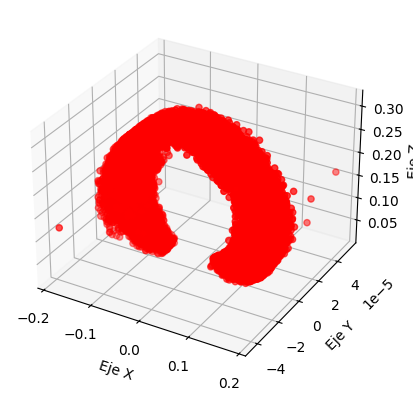

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos de ejemplo
x = X.iloc[:,0]
y = X.iloc[:,1]
z = X.iloc[:,2]

# Crear una figura en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos en 3D
ax.scatter(x, y, z, c='r', marker='o')

# Etiquetas de ejes
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Mostrar la gráfica en 3D
plt.show()

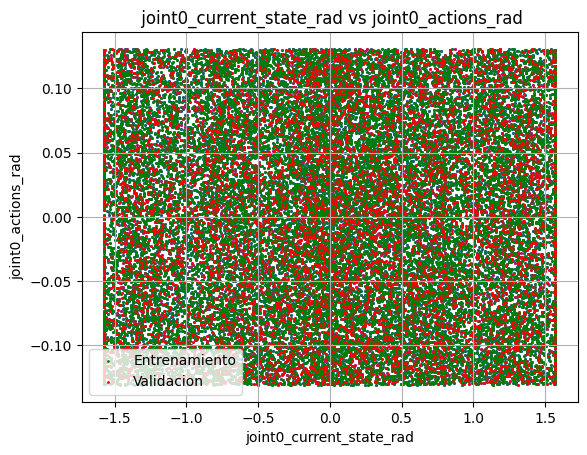

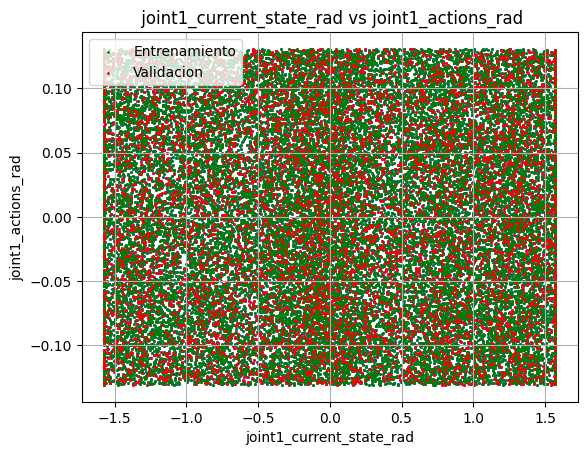

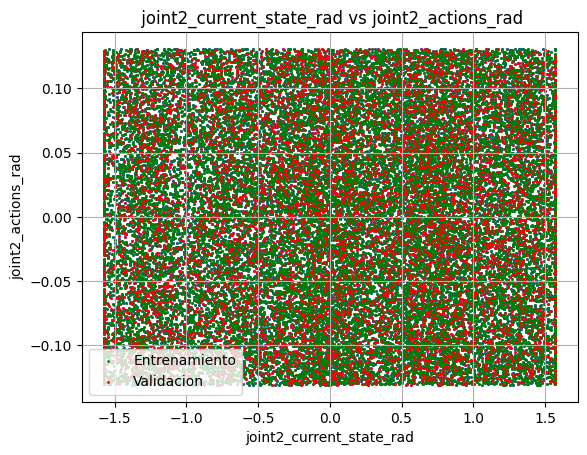

In [ ]:
columns = X_train.columns.tolist()
joints_col = []
for col in columns:
    if "joint" in col:
        joints_col.append(col)
joints_col
joints_n = len(joints_col)//2
for joint in range(joints_n):
    plt.figure()
    state_col = 3 + joint
    act_col = 3 + joint + joints_n
    plt.scatter(X.iloc[:,state_col],X.iloc[:,act_col], s=1, color='blue')
    plt.scatter(X_train.iloc[:,state_col],X_train.iloc[:,act_col], s=1, color='green', label='Entrenamiento')
    plt.scatter(X_test.iloc[:,state_col],X_test.iloc[:,act_col], s=1, color='red', label='Validacion')
    plt.title(f" {columns[state_col]} vs {columns[act_col]}")
    plt.ylabel(columns[act_col])
    plt.xlabel(columns[state_col])
    plt.legend()
    plt.grid()

In [ ]:
file = open("modular02_model" + '.pkl', 'wb')
WorldModel = load_model('C:\\Users\\carlo\\OneDrive\\Imágenes\\Documentos\\GitHub\\EMERGE\\Morphology\\Multimodular\\models\\2023_14_11\\model_modular02__2023_14_11.keras')
pickle.dump(WorldModel, file)

In [ ]:
WorldModel.save("aguardar.keras")

In [ ]:
scene = "modular03"
timestr = time.strftime("_%Y_%d_%m")
models_path = "models\\" + timestr[1:]
if not os.path.exists(models_path):
    os.mkdir(models_path)
    print(f"Directorio '{models_path}' ha sido creado.")
else:
    print(f"El directorio '{models_path}' ya existe.")
text_name = "model_" + str(scene) + ".keras"
WorldModel.save(text_name)

El directorio 'models\2023_21_11' ya existe.
